# Methods and Imports

In [1]:
import numpy as np
import csv
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

# skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam

# prophet
from prophet import Prophet

def calc_avg(lst):
    total = 0
    for element in lst:
        total += element
    if len(lst) < 1:
        return 0
    else:
        return total/len(lst)

def read_data(FILENAME):
    nprocs = []
    runtime = []
    total_jobs = []
    submit_time = []
    core_count = []
    r = []
    
    with open(FILENAME) as file:
        
        tsv_file = csv.reader(file, delimiter="\t")
        field_count = 0
        while int(field_count) < 20:
            field_count = int(len(next(tsv_file)))

        last_time = -1
        last_hour = -1
        job_count = 0
        last_submitted = -1
        i = 0
        for line in tsv_file:
            if (float(line[3]) > -0.5) and (float(line[4]) > -0.5):
                submitted = int(line[1])
                dt = datetime.datetime.fromtimestamp(submitted)

                if last_hour == -1:
                    last_hour = dt.hour
                    last_time = dt
            
                if last_hour != dt.hour:
                    runtime.append(calc_avg(r))
                    nprocs.append(calc_avg(core_count))
                    total_jobs.append(job_count)
                    submit_time.append(last_time.replace(minute=0, second=0, microsecond=0))
                    last_time = dt
                    job_count = 0
                    core_count.clear
                    r.clear
                    
                core_count.append(float(line[4])) # number of allocated processors
                r.append(float(line[3])) # runtime of the job
                job_count += 1
                last_hour = dt.hour
    return submit_time, runtime, nprocs, total_jobs

def read_dataframe():
    submit_time, runtime, nprocs, total_jobs = read_data(FILENAME + '.gwf') #SharcNet
    df = pd.DataFrame(list(zip(submit_time, runtime, nprocs, total_jobs)), columns=['ds', 'RunTime', 'NProcs', 'TotalJobs'])
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.set_index('ds')
    df.to_pickle(FILENAME)
    return df
    
def generate_workload_old(df: pd.DataFrame, target):
    
    f = open(target, 'w', newline='')
    writer = csv.writer(f, lineterminator="\n")  # use linux style line endings
    time_counter = 0
    
    while time_counter < 86400:  # generate for whole day
        # calculating adapted values
        current_hour = int(time_counter / 3600)
        adapted_hour = (current_hour + START_TIME) % 24         
        #print("current hour: " + str(adapted_hour))
        #print("job interval adapted: " + str(adapted_frame['InterArrivalTime']))

        label = ""
        if random.random() > CRITICAL_JOB_RATE:
            label = "not-critical"
        else:
            label = "critical"
        
        total_jobs = int(df.iloc[adapted_hour]['TotalJobs'] * JOB_FACTOR)
        cpu_per_job = int(df.iloc[adapted_hour]['NProcs'] * CPU_FACTOR)
        runtime = int(df.iloc[adapted_hour]['RunTime'] * RUNTIME_FACTOR)
        
        if total_jobs == 0:
            writer.writerow([1, 10, 3600, label])
            time_counter = int(time_counter) + 3600
            continue
        millicores_per_job = 4000 * cpu_per_job / CLUSTER_CPUS 
        job_interval = int(3600/total_jobs)
        write_data = [str(int(millicores_per_job)), str(int(runtime)),
                    str(int(job_interval)), label]
        print(write_data)
        writer.writerow(write_data)
        time_counter = int(time_counter) + int(job_interval)
    f.close()
    
def generate_workload(df: pd.DataFrame, target):
    f = open(target, 'w', newline='')
    writer = csv.writer(f, lineterminator="\n")  # use linux style line endings
    
    for i in range(0,24):
        adapted_hour = (i + START_TIME) % 24
        total_jobs = int(df.iloc[adapted_hour]['TotalJobs'] * JOB_FACTOR)
        millicores_per_job = int(4000 * df.iloc[adapted_hour]['NProcs'] * CPU_FACTOR / CLUSTER_CPUS)
        runtime = int(df.iloc[adapted_hour]['RunTime'] * RUNTIME_FACTOR)
        
        print("HOUR:", adapted_hour)
        print("TOTAL_JOBS", total_jobs)
        print("MILLCORES", millicores_per_job)
        print("RUNTIME", runtime)
        print()
        
        if total_jobs == 0:
            writer.writerow([1, 10, 3600, label]) # placeholder job
            continue
        
        job_interval = int(3600/total_jobs)
        
        for j in range(0,total_jobs):
            label = ""
            if random.random() > CRITICAL_JOB_RATE:
                label = "not-critical"
            else:
                label = "critical"
            write_data = [str(int(millicores_per_job)), str(int(runtime)), str(int(job_interval)), label]
            writer.writerow(write_data)
    f.close()
    
def get_timeframe(df: pd.DataFrame, start_date: datetime.datetime, end_date: datetime.datetime):
    daterange = pd.date_range(start_date, end_date, freq='H')
    result = df.loc[(df.index >= start_date ) & (df.index <= end_date)]
    result = result.reindex(daterange, fill_value=0)
    return result

def get_historical(df: pd.DataFrame, end_date: datetime.datetime):
    start_date = df.index[0]
    end_date -= datetime.timedelta(hours=1)
    daterange = pd.date_range(start_date, end_date, freq='H')
    result = df.loc[(df.index < end_date)]
    result = result.reindex(daterange, fill_value=np.nan)
    return result
    
def get_utilization(df: pd.DataFrame):
    data = df.to_numpy()
    util = []
    
    static = 750/4000
    workload_limit = 3600 * 4000
    for row in data:
        runtime = row[0] * RUNTIME_FACTOR
        nprocs = row[1] * CPU_FACTOR
        totaljobs = row[2] * JOB_FACTOR
        millicores_per_job = nprocs / CLUSTER_CPUS * 4000
        util.append(static + (millicores_per_job * runtime * totaljobs / workload_limit))
    return util, np.mean(util)

def get_predicted_utilization(df: pd.DataFrame):
    data = df.to_numpy()
    util = []
    
    static = 750/4000
    workload_limit = 3600 * 4000
    for row in data:
        runtime = row[3] * RUNTIME_FACTOR
        nprocs = row[4] * CPU_FACTOR
        totaljobs = row[5] * JOB_FACTOR
        millicores_per_job = nprocs / CLUSTER_CPUS * 4000
        util.append(static + (millicores_per_job * runtime * totaljobs / workload_limit))
    return util, np.mean(util)


def df_to_X_y(df, look_back):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-look_back):
        row = [a for a in df_as_np[i:i+look_back]]
        X.append(row)
        label = df_as_np[i+look_back]
        y.append(label[0])
    return np.array(X), np.array(y)

# Constants and Parameters

In [2]:
# job traces filename, without file format ending
# anon_jobs_LCG, anon_jobs_Sharc
FILENAME = 'anon_jobs_Sharc' # 'anon_jobs_Sharc' # 'anon_jobs_LCG'

# specify the timeframe, must be in iso format
FROM = '2006-08-20 00:00:00' # '2006-06-01 00:00:00' # '2005-11-27 00:00:00'
TO = '2006-08-20 23:00:00' # '2006-06-01 23:00:00' # '2005-11-27 23:00:00'

# workload generator parameters
START_TIME = 17 # shifts the generated workload to start at given time
CRITICAL_JOB_RATE = 0.6 # percentage of jobs that should be critical
CLUSTER_CPUS = 6828 # number of cpus in the cluster, depends on job traces
RUNTIME_FACTOR = 1/16 # multiply runtime of each job with a constant value
CPU_FACTOR = 64 # multiply millicores of each job with a constant value
JOB_FACTOR = 1/4 # multiply jobs per hour with a constant value
# If RUNTIME_FACTOR * CPU_FACTOR * JOB_FACTOR = 1 utilization is unchanged
# Used values for benchmark 1 : START_TIME = 17, CRITICAL_JOB_RATE = 0.6, CLUSTER_CPUS = 6828, RUNTIME_FAC = 1/16, CPU_FACTOR = 128, JOB_FACTOR = 1/16
# Used values for benchmark 2 : 

# workload prediction parameters
STEPS = 24 # number of hours predicted by the forecaster


# Read/Load Dataframe

In [3]:
# read or load dataframe
if os.path.exists(FILENAME):
    print("loading pickle...")
    df = pd.read_pickle(FILENAME)
else:
    df = read_dataframe()
df.tail()

loading pickle...


,RunTime,NProcs,TotalJobs
ds,,,
2007-01-15 20:00:00,31829.883378,3.013483,254
2007-01-15 21:00:00,31828.379609,3.013501,58
2007-01-15 22:00:00,31826.919224,3.013525,57
2007-01-15 23:00:00,31825.394948,3.013849,59
2007-01-16 00:00:00,31825.058342,3.013981,13


# Runtime 

('Average runtime per job', 25686.124492692823)

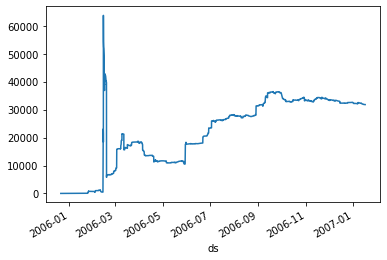

In [4]:
mean = np.mean(df['RunTime'].to_numpy())
df['RunTime'].plot()
"Average runtime per job", mean

# CPU

('Average processors per job', 5.719788094405461)

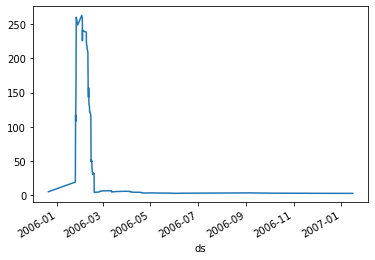

In [5]:
df['NProcs'].plot()
mean = np.mean(df['NProcs'].to_numpy())
"Average processors per job", mean

# Total jobs

('Average jobs', 5.719788094405461)

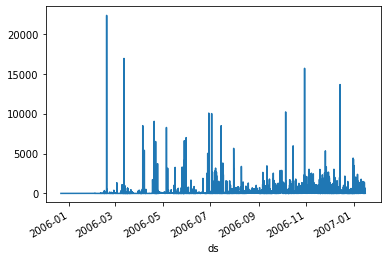

In [6]:
df['TotalJobs'].plot()
mean = np.mean(df['NProcs'].to_numpy())
"Average jobs", mean

# Set Timeframe

In [7]:
# convert strings to datetime
frm = datetime.datetime.fromisoformat(FROM)
to = datetime.datetime.fromisoformat(TO)

timeframe = get_timeframe(df, frm, to)
timeframe.tail()

,RunTime,NProcs,TotalJobs
2006-08-20 19:00:00,27683.999705,3.668330,93
2006-08-20 20:00:00,27681.099540,3.668422,74
2006-08-20 21:00:00,27677.931984,3.668953,57
2006-08-20 22:00:00,27674.373795,3.668708,62
2006-08-20 23:00:00,27670.592935,3.668735,71


# Workload Generation

In [8]:
generate_workload(timeframe, "workload.csv")

HOUR: 17
TOTAL_JOBS 12
MILLCORES 137
RUNTIME 1729

HOUR: 18
TOTAL_JOBS 13
MILLCORES 137
RUNTIME 1729

HOUR: 19
TOTAL_JOBS 23
MILLCORES 137
RUNTIME 1730

HOUR: 20
TOTAL_JOBS 18
MILLCORES 137
RUNTIME 1730

HOUR: 21
TOTAL_JOBS 14
MILLCORES 137
RUNTIME 1729

HOUR: 22
TOTAL_JOBS 15
MILLCORES 137
RUNTIME 1729

HOUR: 23
TOTAL_JOBS 17
MILLCORES 137
RUNTIME 1729

HOUR: 0
TOTAL_JOBS 13
MILLCORES 137
RUNTIME 1733

HOUR: 1
TOTAL_JOBS 15
MILLCORES 137
RUNTIME 1732

HOUR: 2
TOTAL_JOBS 15
MILLCORES 137
RUNTIME 1732

HOUR: 3
TOTAL_JOBS 24
MILLCORES 137
RUNTIME 1732

HOUR: 4
TOTAL_JOBS 13
MILLCORES 137
RUNTIME 1732

HOUR: 5
TOTAL_JOBS 30
MILLCORES 137
RUNTIME 1731

HOUR: 6
TOTAL_JOBS 15
MILLCORES 137
RUNTIME 1731

HOUR: 7
TOTAL_JOBS 12
MILLCORES 137
RUNTIME 1731

HOUR: 8
TOTAL_JOBS 11
MILLCORES 137
RUNTIME 1731

HOUR: 9
TOTAL_JOBS 11
MILLCORES 137
RUNTIME 1731

HOUR: 10
TOTAL_JOBS 11
MILLCORES 137
RUNTIME 1731

HOUR: 11
TOTAL_JOBS 11
MILLCORES 137
RUNTIME 1730

HOUR: 12
TOTAL_JOBS 14
MILLCORES 137
RUNT

# Workload Prediction

In [9]:
# get timeframe with historical data to train the model
timeframe_hist = get_historical(df, frm)

Predict NProcs with Autoregression

In [10]:
nprocs = timeframe_hist[['NProcs']]
nprocs = nprocs.interpolate(method='linear') # interpolating leads to better results
forecaster_nprocs = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 100
             )
forecaster_nprocs.fit(nprocs['NProcs'])
predictions_nprocs = forecaster_nprocs.predict(steps=STEPS)

MAPE 0.0009410427333290155


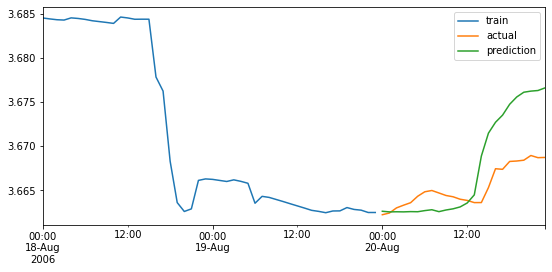

In [11]:
fig, ax = plt.subplots(figsize=(9, 4))
nprocs[-STEPS*2:]['NProcs'].plot(ax=ax, label='train')
timeframe['NProcs'].plot(ax=ax, label='actual')
predictions_nprocs.plot(ax=ax, label='prediction')
ax.legend()
print("MAPE", mape(timeframe['NProcs'],predictions_nprocs))

Predict Runtime with Autoregression

In [12]:
runtime = timeframe_hist[['RunTime']]
runtime = runtime.interpolate(method='linear') # interpolating leads to better results
forecaster_runtime = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 20
             )
forecaster_runtime.fit(runtime['RunTime'])
predictions_runtime = forecaster_runtime.predict(steps=STEPS)

MAPE 0.003586649572380905


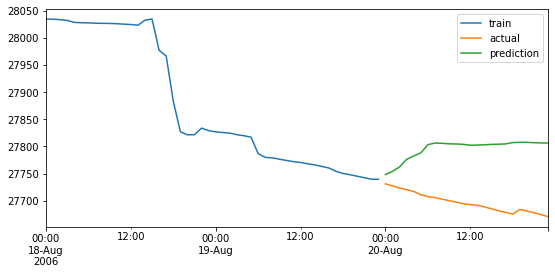

In [13]:
fig, ax = plt.subplots(figsize=(9, 4))
runtime[-STEPS*2:]['RunTime'].plot(ax=ax, label='train')
timeframe['RunTime'].plot(ax=ax, label='actual')
predictions_runtime.plot(ax=ax, label='prediction')
ax.legend()
print("MAPE", mape(timeframe['RunTime'],predictions_runtime))

Predict Total jobs with Autoregression (High MAPE)

In [14]:
totaljobs = timeframe_hist[['TotalJobs']]
totaljobs = totaljobs.fillna(0)
forecaster_totaljobs = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 100
             )
forecaster_totaljobs.fit(totaljobs['TotalJobs'])
predictions_totaljobs_sk = forecaster_totaljobs.predict(steps=STEPS)

MAPE 19.89930849855951


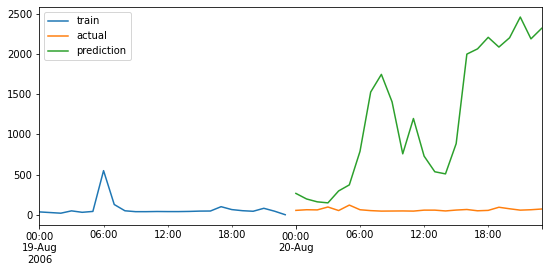

In [15]:
fig, ax = plt.subplots(figsize=(9, 4))
totaljobs[-STEPS:]['TotalJobs'].plot(ax=ax, label='train')
timeframe['TotalJobs'].plot(ax=ax, label='actual')
predictions_totaljobs_sk.plot(ax=ax, label='prediction')
ax.legend()
print("MAPE", mape(timeframe['TotalJobs'],predictions_totaljobs_sk))

Predict TotalJobs with Prophet (preffered method)

c:\Users\moria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG Adding TBB (c:\Users\moria\AppData\Local\Programs\Python\Python37\lib\site-packages\prophet\stan_model\cmdstan-2.26.1\stan\lib\stan_math\lib\tbb) to PATH
prophet    INFO  Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: C:\Users\moria\AppData\Local\Temp\tmpngs8jcl4\eft76frg.json
cmdstanpy  DEBUG input tempfile: C:\Users\moria\AppData\Local\Temp\tmpngs8jcl4\7z0kpnzl.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan

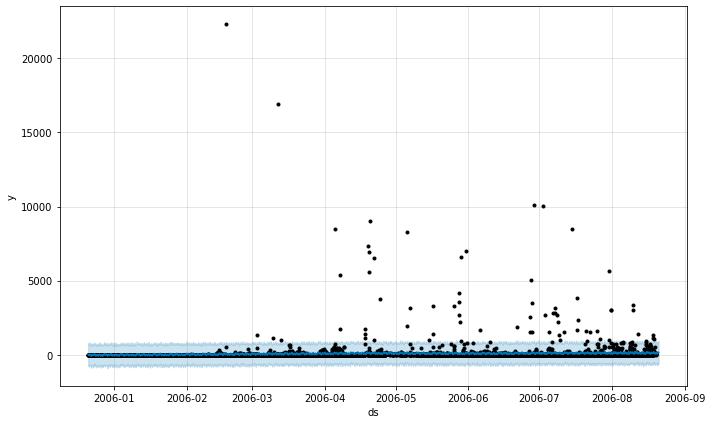

In [16]:
totaljobs = timeframe_hist[['TotalJobs']]
totaljobs['ds'] = totaljobs.index
totaljobs = totaljobs.rename(columns={'TotalJobs':'y'})
totaljobs = totaljobs.fillna(0)

m_totaljobs = Prophet()
m_totaljobs.fit(totaljobs)

future_totaljobs = m_totaljobs.make_future_dataframe(periods=24, freq='H')
future_totaljobs.tail()

forecast_totaljobs = m_totaljobs.predict(future_totaljobs)

fig1 = m_totaljobs.plot(forecast_totaljobs)

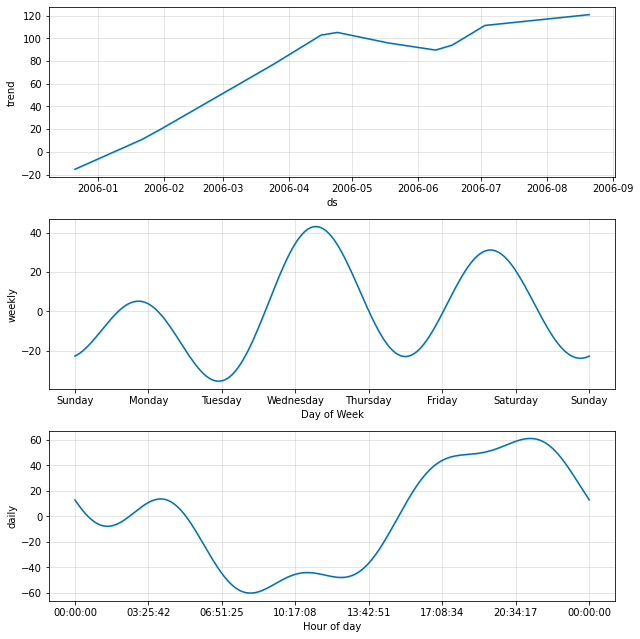

In [17]:
fig2 = m_totaljobs.plot_components(forecast_totaljobs)

MAPE 0.9031466819154325


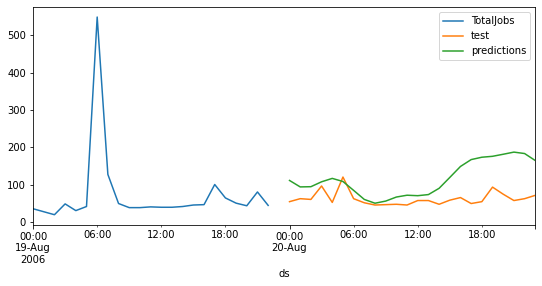

In [18]:
forecast_totaljobs.index = forecast_totaljobs['ds']
fig, ax = plt.subplots(figsize=(9, 4))
timeframe_hist[['TotalJobs']][-STEPS:].plot(ax=ax, label='train')
timeframe['TotalJobs'].plot(ax=ax, label='test')
forecast_totaljobs['yhat'][-STEPS:].plot(ax=ax, label='predictions')
ax.legend()
print("MAPE", mape(timeframe['TotalJobs'],forecast_totaljobs['yhat'][-STEPS:]))

In [19]:
timeframe['predicted RunTime'] = predictions_runtime
timeframe['predicted NProcs'] = predictions_nprocs
timeframe['predicted TotalJobs'] = forecast_totaljobs['yhat'][-STEPS:]
timeframe.tail()

,RunTime,NProcs,TotalJobs,predicted RunTime,predicted NProcs,predicted TotalJobs
2006-08-20 19:00:00,27683.999705,3.668330,93,27807.701096,3.675568,175.607090
2006-08-20 20:00:00,27681.099540,3.668422,74,27807.653991,3.676106,181.112937
2006-08-20 21:00:00,27677.931984,3.668953,57,27806.978687,3.676231,186.860895
2006-08-20 22:00:00,27674.373795,3.668708,62,27806.566276,3.676299,183.046131
2006-08-20 23:00:00,27670.592935,3.668735,71,27806.319339,3.676596,164.255407


Actual workload

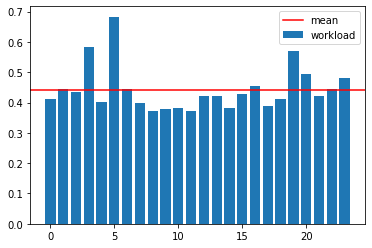

In [20]:
util, mean = get_utilization(timeframe)
plt.bar(range(0,24), util, label="workload")
plt.axhline(y=mean, color='r', linestyle='-', label="mean")
plt.legend()

In [21]:
mean

0.44288271352367053

Predicted Workload

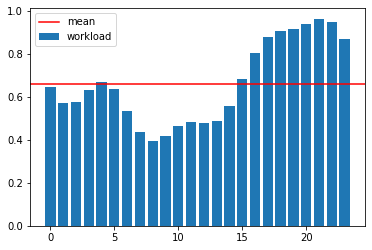

In [22]:
predicted_util, predicted_mean = get_predicted_utilization(timeframe)
plt.bar(range(0,24), predicted_util, label="workload")
plt.axhline(y=predicted_mean, color='r', linestyle='-', label="mean")
plt.legend()

In [23]:
predicted_mean

0.6627514204488821

In [24]:
predicted_mean/mean

1.4964490602396483

MAPE of the workload prediction

In [25]:
mape(util, predicted_util)

0.5128519631699439

In [26]:
# save the workload prediction
np.savetxt("workload_prediction.csv", predicted_util, delimiter=",")

# save the runtime prediction
predicted_runtime = timeframe['predicted RunTime'].to_numpy() * RUNTIME_FACTOR
np.savetxt("runtime_prediction.csv", predicted_runtime.astype(int), delimiter=",")